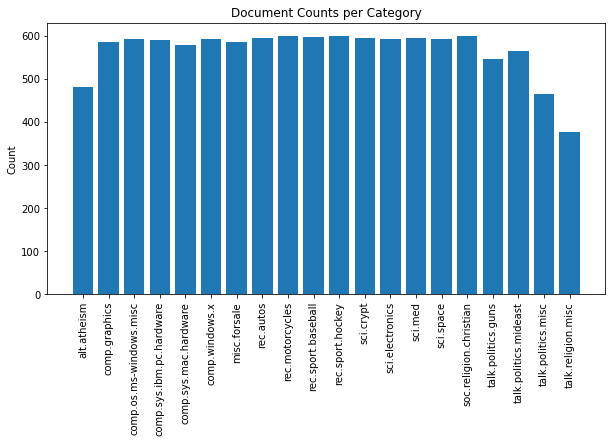

In [75]:
#Q1
import numpy as np
np.random.seed(42)
import random
random.seed(42)

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups

plt.rcParams['figure.figsize'] = [10,5]

twenty_plot = fetch_20newsgroups(subset='train')
labels = twenty_plot.target_names

y = list(range(20))
for i in range(20):
    y[i] = np.count_nonzero(twenty_plot.target == i)

plt.bar(labels,y)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Document Counts per Category")
plt.show()

In [102]:
#Q2
#Questions for TA:
#random_state for dataset fetch? None or 42? 42 used in discussion but project doc says None

import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from nltk.corpus import stopwords

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

lemur = nltk.wordnet.WordNetLemmatizer()

#Vectorizer
analyzer = CountVectorizer().build_analyzer()
tfidf_transformer = TfidfTransformer()

#Download dataset
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42) #should 42 be None?
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42)

combined_stopwords = set.union(set(stopwords.words('english')),set(punctuation))

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(text):
    return [lemur.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(text)]

#Updated analyzer to avoid counting digits and punctuation
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc, stop_words='english')

corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]

#X_train_counts = count_vect.fit_transform(corpus)

X_train_counts = count_vect.fit_transform(train_dataset.data)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(test_dataset.data)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("X_train shape: ", X_train_tfidf.shape)
print("X_test shape: ", X_test_tfidf.shape)



X_train shape:  (4732, 16466)
X_test shape:  (3150, 16466)


In [ ]:
#Q3
#Questions for TA:
#random_state for nmf and trunc svd? 0 or 42? 

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.utils.extmath import randomized_svd

trunc_svd = TruncatedSVD(n_components=50, random_state=42)
X_train_lsi = trunc_svd.fit_transform(X_train_tfidf)
X_test_lsi = trunc_svd.transform(X_test_tfidf)

#Get trunc svd matrices
#https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn
U, Sigma, VT = randomized_svd(X_train_tfidf, n_components=50, random_state=42)
Sigma = np.diag(Sigma) #Make sigma values a diag matrix rather than nx1

nmf_model = NMF(n_components=50, init='random', random_state=42, max_iter=1000)
X_train_nmf = nmf_model.fit_transform(X_train_tfidf)
X_test_nmf = nmf_model.transform(X_test_tfidf)
H = nmf_model.components_
error_lsi = np.sum(np.array(X_train_tfidf - U.dot(Sigma.dot(VT)))**2)
error_nmf = np.sum(np.array(X_train_tfidf - X_train_nmf.dot(H))**2)

print('LSI Train error: ', error_lsi)
print('NMF Train error: ', error_nmf)

print('LSI Train shape: ', X_train_lsi.shape)
print('LSI Test shape: ', X_test_lsi.shape)
print('NMF Train shape: ', X_train_nmf.shape)
print('NMF Test shape: ', X_test_nmf.shape)

In [ ]:
#Q4
from sklearn.svm import LinearSVC
from sklearn import metrics

#Start by changing to binary classification
train_targets_bin = train_dataset.target.copy()
for i in range(len(train_targets_bin)):
    if train_dataset.target[i] in [0,1,2,3]:
        train_targets_bin[i] = 0
    else:
        train_targets_bin[i] = 1
        
test_targets_bin = test_dataset.target.copy()
for i in range(len(test_targets_bin)):
    if test_dataset.target[i] in [0,1,2,3]:
        test_targets_bin[i] = 0
    else:
        test_targets_bin[i] = 1

#Train hard and soft margin SVCs - using LSI data per instructions - then get stats
soft_margin_SVC = LinearSVC(C=0.0001,max_iter=90000).fit(X_train_lsi, train_targets_bin)
soft_margin_prediction = soft_margin_SVC.predict(X_test_lsi)

hard_margin_SVC = LinearSVC(C=1000,max_iter=90000).fit(X_train_lsi, train_targets_bin)
hard_margin_prediction = hard_margin_SVC.predict(X_test_lsi)

fpr_soft, tpr_soft, thresholds_soft = metrics.roc_curve(test_targets_bin, soft_margin_prediction, pos_label=1)
fpr_hard, tpr_hard, thresholds_hard = metrics.roc_curve(test_targets_bin, hard_margin_prediction, pos_label=1)

#I stole this helper function from the discussion notebook!
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = metrics.auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
        
#Show the stats for our model (part 1 of question)       
plot_roc(fpr_soft,tpr_soft)
metrics.plot_confusion_matrix(soft_margin_SVC, X_test_lsi, test_targets_bin)
print("Soft margin prediction stats:")
print(metrics.classification_report(test_targets_bin,soft_margin_prediction,digits=4))

plot_roc(fpr_hard,tpr_hard)
metrics.plot_confusion_matrix(hard_margin_SVC, X_test_lsi, test_targets_bin)
print("Hard margin prediction stats:")
print(metrics.classification_report(test_targets_bin,hard_margin_prediction,digits=4))

#hard margin is much better than soft!

#Part 2!
def find_best_gamma(ks):
    best_k = -100
    best_acc = 0
    for i in ks: 
        k_SVC = LinearSVC(C=10**i,max_iter=90000).fit(X_train_lsi, train_targets_bin)
        k_prediction = k_SVC.predict(X_test_lsi)
        scores = metrics.confusion_matrix(test_targets_bin,k_prediction)
        acc = (scores[0][0]+ scores[1][1])/(scores[0][0]+ scores[0][1] + scores[1][0]+ scores[1][1])
        if acc > best_acc:
            best_k = i
            best_acc = acc
    return best_k
        
        
k = find_best_gamma([-3,-2,-1,0,1,2,3])

#recalculate model w/best k and report stats
optimal_SVC = LinearSVC(C=10**k,max_iter=50000).fit(X_train_lsi, train_targets_bin)
optimal_prediction = optimal_SVC.predict(X_test_lsi)
fpr_opt, tpr_opt, thresholds_opt = metrics.roc_curve(test_targets_bin, optimal_prediction, pos_label=1)
plot_roc(fpr_opt,tpr_opt)
metrics.plot_confusion_matrix(optimal_SVC, X_test_lsi, test_targets_bin)
print("Optimal prediction stats:")
print(metrics.classification_report(test_targets_bin,optimal_prediction,digits=4))


In [ ]:
#Q5 
from sklearn.linear_model import LogisticRegression
#Part 1
#C is "Inverse of regularization strength", so a really big value approximates no regularization
log_class_no_reg = LogisticRegression(C=9999999999,solver='liblinear').fit(X_train_lsi, train_targets_bin)
log_class_no_reg_prediction = log_class_no_reg.predict(X_test_lsi)

fpr, tpr, threshold = metrics.roc_curve(test_targets_bin, log_class_no_reg_prediction, pos_label=1)

plot_roc(fpr,tpr)
metrics.plot_confusion_matrix(log_class_no_reg, X_test_lsi, test_targets_bin)
print("Non-regularized logistic classifier stats:")
print(metrics.classification_report(test_targets_bin,log_class_no_reg_prediction,digits=4))

#Part 2a - finding best regularization parameter
def find_best_reg(ks, reg_type):
    best_k = -100
    best_acc = 0
    for i in ks: 
        k_LR = LogisticRegression(C=10**i, penalty=reg_type,solver='liblinear').fit(X_train_lsi, train_targets_bin)
        k_prediction = k_LR.predict(X_test_lsi)
        scores = metrics.confusion_matrix(test_targets_bin,k_prediction)
        acc = (scores[0][0]+ scores[1][1])/(scores[0][0]+ scores[0][1] + scores[1][0]+ scores[1][1])
        if acc > best_acc:
            best_k = i
            best_acc = acc
    return best_k

k_l1 = find_best_reg([-3,-2,-1,0,1,2,3], "l1")
k_l2 = find_best_reg([-3,-2,-1,0,1,2,3], "l2")

#part 2b: getting stats for optimal l1 and l2 reg parameters (no-reg done in part 1)

#l1 case
log_class_l1 = LogisticRegression(C=10**k_l1, penalty="l1",solver='liblinear').fit(X_train_lsi, train_targets_bin)
log_class_l1_prediction = log_class_l1.predict(X_test_lsi)

fpr_l1, tpr_l1, threshold_l1 = metrics.roc_curve(test_targets_bin, log_class_l1_prediction, pos_label=1)

plot_roc(fpr_l1,tpr_l1)
metrics.plot_confusion_matrix(log_class_l1, X_test_lsi, test_targets_bin)
print("L1 logistic classifier stats with C = " + str(k_l1))
print(metrics.classification_report(test_targets_bin,log_class_l1_prediction,digits=4))

#l2 case
log_class_l2 = LogisticRegression(C=10**k_l2, penalty="l2",solver='liblinear').fit(X_train_lsi, train_targets_bin)
log_class_l2_prediction = log_class_l2.predict(X_test_lsi)

fpr_l2, tpr_l2, threshold_l2 = metrics.roc_curve(test_targets_bin, log_class_l2_prediction, pos_label=1)

plot_roc(fpr_l2,tpr_l2)
metrics.plot_confusion_matrix(log_class_l2, X_test_lsi, test_targets_bin)
print("L2 logistic classifier stats with C = " + str(k_l2))
print(metrics.classification_report(test_targets_bin,log_class_l2_prediction,digits=4))



Naive Bayes classification stats:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      1560
           1       0.83      0.98      0.90      1590

    accuracy                           0.89      3150
   macro avg       0.90      0.89      0.89      3150
weighted avg       0.90      0.89      0.89      3150



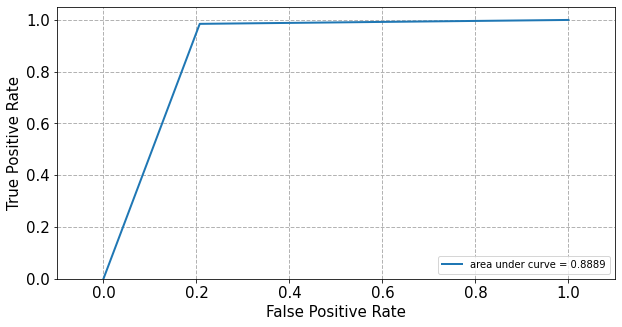

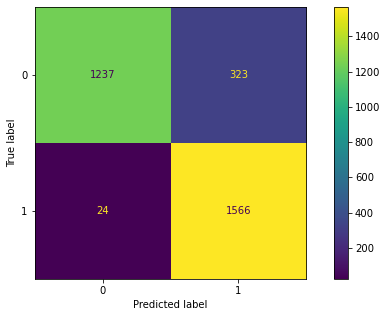

In [95]:
#Q6
from sklearn.naive_bayes import GaussianNB

gauss_NB = GaussianNB().fit(X_train_lsi, train_targets_bin)
gauss_NB_prediction = gauss_NB.predict(X_test_lsi)

fpr_NB, tpr_NB, threshold_NB = metrics.roc_curve(test_targets_bin, gauss_NB_prediction, pos_label=1)

plot_roc(fpr_NB,tpr_NB)
metrics.plot_confusion_matrix(gauss_NB, X_test_lsi, test_targets_bin)
print("Naive Bayes classification stats:")
print(metrics.classification_report(test_targets_bin,gauss_NB_prediction))

In [ ]:
#Q7
#Can we do two grid searches, one for each set of data, then pick the best of the two for our best parameters?
#Are we allowed to remove headers/footers when loading in the data? Instead of using the code given to us
#What is test score rank? From table or from evaluating on the test set? For the former, do we take the best performance between the two datasets?
# How will it be graded? What if my best combination is different that your default one?

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
import pandas as pd

import joblib

def stem_rmv_punc_nolem(doc):
    return (word for word in analyzer(doc) if word not in combined_stopwords and not word.isdigit())

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

#Get train and test set with no headers/footers, and turn classification to binary
train_dataset_nohf = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42, remove=('headers','footers'))
test_dataset_nohf = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42, remove=('headers','footers'))

train_targets_nohf_bin = train_dataset_nohf.target.copy()
for i in range(len(train_targets_nohf_bin)):
    if train_dataset_nohf.target[i] in [0,1,2,3]:
        train_targets_nohf_bin[i] = 0
    else:
        train_targets_nohf_bin[i] = 1
        
test_targets_nohf_bin = test_dataset_nohf.target.copy()
for i in range(len(test_targets_nohf_bin)):
    if test_dataset_nohf.target[i] in [0,1,2,3]:
        test_targets_nohf_bin[i] = 0
    else:
        test_targets_nohf_bin[i] = 1

#init pipeline       
cachedir = mkdtemp()
memory = joblib.Memory(cachedir=cachedir, verbose=10)
pipeline = Pipeline([
    ('vect', None),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', None),
    ('clf', None),
],
memory=memory
)

#define pipeline params
param_grid = [
    {
        'vect': [CountVectorizer(analyzer=stem_rmv_punc, stop_words='english'), CountVectorizer(analyzer=stem_rmv_punc_nolem, stop_words='english')],
        'reduce_dim': [NMF(n_components=50, init='random', random_state=42, max_iter=1000), TruncatedSVD(n_components=50, random_state=42)],
        'clf': [LogisticRegression(C=10, penalty="l2", solver='liblinear', max_iter=10000), LogisticRegression(C=10, penalty="l1", solver='liblinear', max_iter=10000), LinearSVC(C=1, max_iter=100000),  GaussianNB()],
        'vect__min_df':[3,5],
    },
]

models_in = {
    'Pipeline': pipeline
}

params_in = {
    'Pipeline': param_grid
}

#Run grid search
grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit(train_dataset.data, train_targets_bin, n_jobs=1, cv=5, scoring='accuracy')
grid_search.score_summary(sort_by='mean_score')


#grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
#grid.fit(train_dataset.data, train_targets_bin)
#print(pd.DataFrame(grid.cv_results_))

In [ ]:
grid_search.fit(train_dataset_nohf.data, train_targets_nohf_bin, n_jobs=1, cv=5, scoring='accuracy')
grid_search.score_summary(sort_by='mean_score')
rmtree(cachedir)

In [ ]:
#Q7

#Models with best params (min_df = 3 by default the best)
model_l2 = LogisticRegression(C=10, penalty="l2", solver='liblinear', max_iter=10000)
model_l1 = LogisticRegression(C=10, penalty="l1", solver='liblinear', max_iter=10000)
model_svc = LinearSVC(C=1, max_iter=100000)
model_gaus = GaussianNB()

#Header/footer included performance using best params
model_l1.fit(X_train_lsi,train_targets_bin)
best_predict = model_l1.predict(X_test_lsi)
print(metrics.classification_report(test_targets_bin,best_predict,digits=4))


#No header/footer performance using best params
X_train_counts_nohf = count_vect.fit_transform(train_dataset_nohf.data)
X_train_tfidf_nohf = tfidf_transformer.fit_transform(X_train_counts_nohf)

X_test_counts_nohf = count_vect.transform(test_dataset_nohf.data)
X_test_tfidf_nohf = tfidf_transformer.transform(X_test_counts_nohf)

X_train_lsi_nohf = trunc_svd.fit_transform(X_train_tfidf_nohf)
X_test_lsi_nohf = trunc_svd.transform(X_test_tfidf_nohf)

model_l1.fit(X_train_lsi_nohf,train_targets_nohf_bin)
best_predict_nohf = model_l1.predict(X_test_lsi_nohf)
print(metrics.classification_report(test_targets_nohf_bin,best_predict_nohf,digits=4))

In [ ]:
#Q9 

embeddings_dict = {}
dimension_of_glove = 300
glove_file = "glove.6B."+ str(dimension_of_glove) + "d.txt"

with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector      



In [ ]:
from sklearn.preprocessing import normalize


def glove_preprocess(input_data, input_target):
    first_vect = 0
    doc_num = 0

    #Keep track of which docs have no embeddings so that we remove those indices from the target values
    bad_doc_index_list = []
    
    for doc in input_data:
        found_subj = 0
        found_key = 0
        final_str = ""
        
        #Take subject and keywords lines, and also remove the fwd/re.
        for line in doc.splitlines():
            if (not(found_subj and found_key)):
                if ("Subject:" in line and not found_subj):
                    final_str += " " + line.replace("Subject:", "").replace("Re:","").replace("Fwd:","")
                    found_subj = 1
                elif("subject:" in line and not found_subj):
                    final_str += " " + line.replace("subject:", "").replace("Re:","").replace("Fwd:","")
                    found_subj = 1
                elif("Keywords:" in line and not found_key):
                    final_str += " " + line.replace("Keywords:", "").replace("Re:","").replace("Fwd:","")
                    found_key = 1
                elif("keywords:" in line and not found_key):
                    final_str += " " + line.replace("keywords:", "").replace("Re:","").replace("Fwd:","")
                    found_key = 1
        temp = np.zeros((1,dimension_of_glove))

        count = 0
        
        #Lemmatize each word, then normalize and add to temp
        for elem in stem_rmv_punc(final_str):
            if (elem in embeddings_dict.keys()):
                count += 1
                temp += normalize(embeddings_dict[elem].reshape(-1,1)).T

        #Only add vector to training matrix if embeddings were found
        if (count != 0):
            
            #Take divide by the count to average out the word vectors for the doc
            temp /= count
            if (first_vect == 0):
                glove_data = temp
                first_vect = 1
            else:
                glove_data = np.concatenate((glove_data, temp), axis=0)
        else:
            bad_doc_index_list.append(doc_num)

        doc_num += 1

    
    glove_targets = input_target.copy()
    glove_targets = np.delete(glove_targets, bad_doc_index_list, axis=0)
    return glove_data, glove_targets


In [ ]:
glove_train, glove_train_targets = glove_preprocess(train_dataset.data,train_targets_bin)
glove_test, glove_test_targets = glove_preprocess(test_dataset.data,test_targets_bin)

model_l1.fit(glove_train, glove_train_targets)
glove_predict = model_l1.predict(glove_test)
print(metrics.classification_report(glove_test_targets,glove_predict,digits=4))

In [ ]:

#Q10
from sklearn.metrics import accuracy_score

test_accuracies = []
dims = [50, 100, 200, 300]
for dim in dims:
    
    embeddings_dict = {}
    dimension_of_glove = dim
    glove_file = "glove.6B."+ str(dimension_of_glove) + "d.txt"

    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector      
    
    glove_train, glove_train_targets = glove_preprocess(train_dataset.data,train_targets_bin)
    glove_test, glove_test_targets = glove_preprocess(test_dataset.data,test_targets_bin)
    model_l1.fit(glove_train, glove_train_targets)
    glove_predict = model_l1.predict(glove_test)
    test_accuracies.append(accuracy_score(glove_test_targets,glove_predict))

plt.figure()
plt.scatter(dims, test_accuracies)
plt.title("GLoVE Embedding Dimension vs. Test Accuracy")
plt.xlabel("Dimension")
plt.ylabel("Test Accuracy")
plt.show()